# Using Random Forest Classifiers for Biomarker Mining:

**Description**: This notebook allows the user to perform Biomarker Mining on a .csv file of gene expression data generated from SpaceRanger Output. To get this output, please use the spaceranger_dataextract notebook. The method used is **Random Forest Classifiers (RFCs)**.

**Methodology**: This method of biomarker mining starts from a set of previously determined biologically-meaningful biomarkers. The basic idea is that we utilize a Bi-Moran hotspot analysis methodology (included separately). This yields certain regions of High-High or Low-High barcodes. To find other informative biomarkers, we perform binary random forest classification on the entire sample. For simplicity, the hotspot region is labeled "1" and the non-hotspot region is labeled "0". After training, the RFC is evaluated on a held out test set. Finally, if the RFC has achieved good performance, we would hope that the features closer to the root of the individual decision trees provide the maximum information gain that allows for the identification of the *same hotspot region* that was previously identified using Bi-Moran methods. 

In essence, we find *biomarkers that are similar to other provided biomarkers* in their predictive capibilites in identifying notable hotsposts in a heterogeneous tumor sample. Of course, this type of analysis can be used for other similar purposes as well.

In [1]:
import csv
import gzip
import os
import scipy.io
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.svm import SVC as svc
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.preprocessing import OneHotEncoder as ohe
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance

In [2]:
os.chdir("../data/F8_37_human_outs")
!pwd

/Users/cmitra/Desktop/spatial_anlys_tumor_het/data/F8_37_human_outs


## 1. Extract Data From CSV:

In [3]:
#Start from here, above code was to create csv
matrix = pd.read_csv("F8_37_human_matrix.csv")

In [4]:
matrix.columns

Index(['feature_id', 'gene', 'feature_type', 'AAACAAGTATCTCCCA-1',
       'AAACAATCTACTAGCA-1', 'AAACAGAGCGACTCCT-1', 'AAACAGCTTTCAGAAG-1',
       'AAACAGGGTCTATATT-1', 'AAACCCGAACGAAATC-1', 'AAACCGGAAATGTTAA-1',
       ...
       'TTGTGGTATAGGTATG-1', 'TTGTGTATGCCACCAA-1', 'TTGTGTTTCCCGAAAG-1',
       'TTGTTAGCAAATTCGA-1', 'TTGTTCAGTGTGCTAC-1', 'TTGTTGTGTGTCAAGA-1',
       'TTGTTTCACATCCAGG-1', 'TTGTTTCATTAGTCTA-1', 'TTGTTTCCATACAACT-1',
       'TTGTTTGTGTAAATTC-1'],
      dtype='object', length=3527)

In [5]:
matrix.to_numpy().shape

(37733, 3527)

In [6]:
#matrix.loc[matrix["gene"] == "FASN"]

In [7]:
#matrix.loc[matrix["gene"] == "LDHA"]

## 2. Identifying Unexpressed Genes:

In [8]:
blank_list = []
for i in range(36601):
    #if i%100 == 0:
        #print(i)
    if matrix.iloc[i][3:].sum() == 0:
        blank_list.append(i)

In [9]:
print(len(blank_list))
blank_list[0:10]

14022


[0, 1, 2, 4, 5, 7, 10, 12, 13, 18]

In [10]:
#Ideas:
#Filter out zeros for all samples
#Summary statistics for each row
#Getting the top 5 most expressed genes for each coordinate and creating some kind of map or probability distro
#Apply Decision Trees, RFCs, or Gradient Boosting onto each sample using Dr. Erdogan's labels.
#Include all of this in paper

## 3. Creating Separate Tables for Genes and Expressions:

In [11]:
matrix.drop(columns=["feature_id", "feature_type"], inplace=True)
matrix.shape

(37733, 3525)

In [12]:
all_filtered = matrix.T
all_filtered.drop(columns=blank_list, axis=1, inplace=True)
#all_filtered.drop("gene", inplace=True)
all_filtered.head()

,3,6,8,9,11,14,15,16,17,19,...,37723,37724,37725,37726,37727,37728,37729,37730,37731,37732
gene,ENSG00000238009,ENSG00000241860,ENSG00000286448,ENSG00000236601,ENSG00000235146,LINC01409,FAM87B,LINC00115,LINC01128,FAM41C,...,ENSG00000275249,ENSG00000274792,ENSG00000274175,ENSG00000275869,ENSG00000273554,ENSG00000277836,ENSG00000278633,ENSG00000276017,ENSG00000278817,ENSG00000277196
AAACAAGTATCTCCCA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
AAACAATCTACTAGCA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACAGAGCGACTCCT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
AAACAGCTTTCAGAAG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
genes = all_filtered.values[0]
features = all_filtered.values[1:]
features.shape

(3524, 23711)

In [14]:
print(genes)

['ENSG00000238009' 'ENSG00000241860' 'ENSG00000286448' ...
 'ENSG00000276017' 'ENSG00000278817' 'ENSG00000277196']


## 4. RFC Gene Mining:

We will need a .csv output from the hotspot analysis mentioned previously.

In [15]:
hotspot_data = pd.read_csv("/Users/cmitra/Downloads/unimoran_tff1.csv")

In [16]:
hotspot_data.head()

,Unnamed: 0,barcode,LDHA,GREB1,TFF1,FASN,MKI67,PCNA,in_tissue,array_row,array_col,pxl_row,pxl_col,labels (p_thresh=0.001),labels (p_thresh=0.002),labels (p_thresh=0.005),labels (p_thresh=0.01),labels (p_thresh=0.05),labels (p_thresh=0.1)
0,0,AAACAAGTATCTCCCA-1,0.693147,1.386294,5.099866,2.890372,1.386294,0.693147,1,50,102,1465,1693,Not Significant,Not Significant,Not Significant,Not Significant,Not Significant,Not Significant
1,1,AAACAATCTACTAGCA-1,2.197225,0.000000,4.574711,2.772589,0.000000,0.693147,1,3,43,332,871,Not Significant,Not Significant,Not Significant,Not Significant,Not Significant,Not Significant
2,2,AAACAGAGCGACTCCT-1,1.609438,1.098612,4.143135,2.564949,0.000000,1.098612,1,14,94,596,1580,Not Significant,Not Significant,Low-Low,Low-Low,Low-Low,Low-Low
3,3,AAACAGCTTTCAGAAG-1,1.609438,0.693147,5.087596,2.484907,0.000000,0.000000,1,43,9,1300,401,Not Significant,Not Significant,Not Significant,High-High,High-High,High-High
4,4,AAACAGGGTCTATATT-1,1.386294,0.693147,5.049856,3.091042,0.000000,1.098612,1,47,13,1396,457,Not Significant,High-High,High-High,High-High,High-High,High-High


In [17]:
hotspot_data.shape

(3524, 19)

In [127]:
yang_list = list(hotspot_data["barcode"])
#print(yang_list)

In [128]:
features

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=object)

In [129]:
y_5 = hotspot_data.drop(hotspot_data.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18]], axis=1)
y_1 = hotspot_data.drop(hotspot_data.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,18]], axis=1)

In [130]:
y_5.head()

,labels (p_thresh=0.05)
0,Not Significant
1,Not Significant
2,Low-Low
3,High-High
4,High-High


In [131]:
y_5 = y_5.values.flatten()
y_1 = y_1.values.flatten()

In [132]:
for i in range(len(y_5)):
    if y_5[i] == "High-High":# or y_5[i] == "Low-High":
        y_5[i] = 1
    else:
        y_5[i] = 0
    if y_1[i] == "High-High":# or y_1[i] == "Low-High":
        y_1[i] = 1
    else:
        y_1[i] = 0

In [133]:
y_5 = y_5.astype('int')
y_1 = y_1.astype('int')
y_5.shape

(3524,)

In [134]:
X_train, X_test, y_train, y_test = train_test_split(features, y_5, test_size=.2, random_state=0, shuffle=True, stratify=y_5)

In [135]:
rfc_model = rfc(random_state=0, criterion="entropy")

In [136]:
rfc_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=0)

In [137]:
rfc_model.score(X_test, y_test)

0.8936170212765957

To visualize the different decision tree "sub-estimators" that are used in the RFC ensemble, change the dtree value from 0 to 100 as that is the default value. For more information, please refer to the [Scikit-Learn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) on RFCs.

[Text(0.45948877427184465, 0.9705882352941176, 'RPS15 <= 57.5\nentropy = 0.725\nsamples = 1794\nvalue = [2251, 568]'),
 Text(0.18349514563106797, 0.9117647058823529, 'RPL30 <= 58.5\nentropy = 0.26\nsamples = 865\nvalue = [1329, 61]'),
 Text(0.1145631067961165, 0.8529411764705882, 'CHRNA10 <= 0.5\nentropy = 0.16\nsamples = 582\nvalue = [921, 22]'),
 Text(0.08155339805825243, 0.7941176470588235, 'RPL41 <= 169.0\nentropy = 0.127\nsamples = 568\nvalue = [903, 16]'),
 Text(0.07378640776699029, 0.7352941176470589, 'RPL11 <= 7.5\nentropy = 0.114\nsamples = 567\nvalue = [903, 14]'),
 Text(0.031067961165048542, 0.6764705882352942, 'CD9 <= 3.5\nentropy = 0.419\nsamples = 42\nvalue = [54, 5]'),
 Text(0.015533980582524271, 0.6176470588235294, 'PSMD7 <= 1.5\nentropy = 0.133\nsamples = 38\nvalue = [53, 1]'),
 Text(0.007766990291262136, 0.5588235294117647, 'entropy = 0.0\nsamples = 37\nvalue = [53, 0]'),
 Text(0.02330097087378641, 0.5588235294117647, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Te

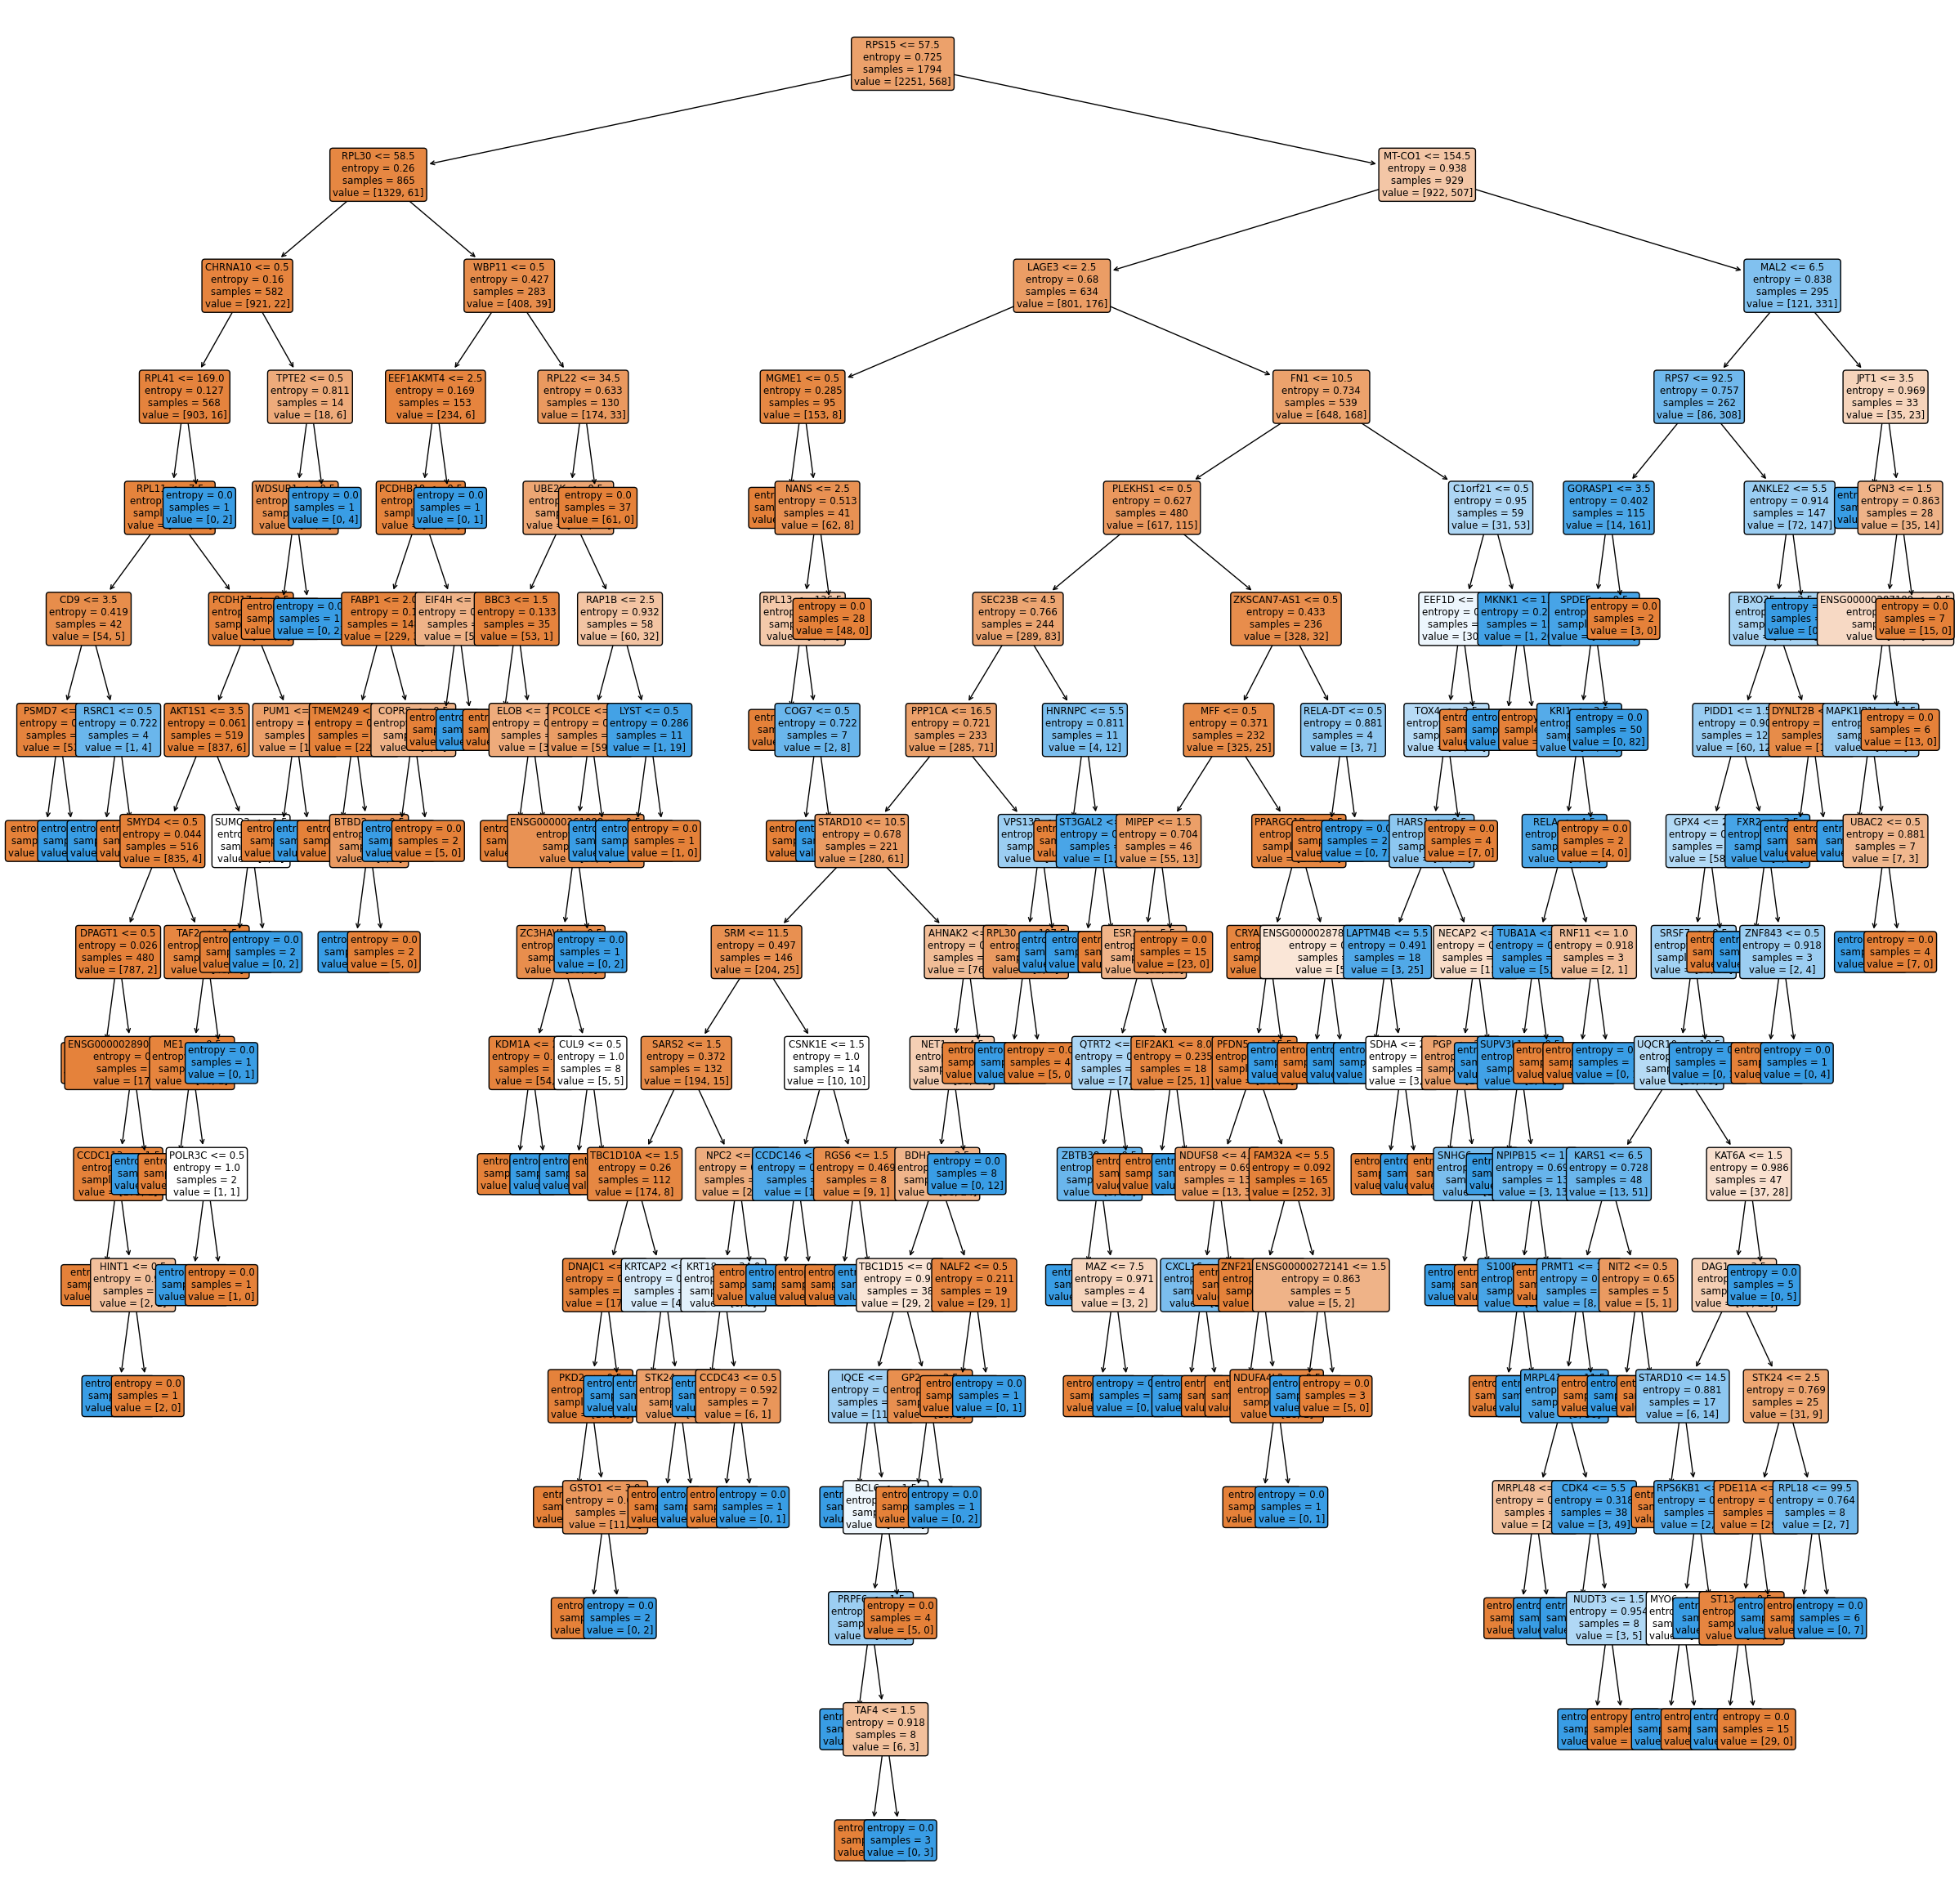

In [138]:
from sklearn import tree
dtree= 3
plt.figure(figsize=(30,30))
tree.plot_tree(rfc_model.estimators_[dtree],
                feature_names=genes,
                filled=True,
                rounded=True,
              fontsize=8.5)

## 5. RFC Feature Importance Analysis (w/out sensitivity analysis):

**Note:** Code taken from [Scikit-Learn](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#feature-importance-based-on-mean-decrease-in-impurity) - Remember to cite

In [140]:
import time
import numpy as np

start_time = time.time()
importances = rfc_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc_model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.180 seconds


In [153]:
importances_sorted = np.sort(importances)[-10:][::-1]
importances_arg_sorted = np.argsort(importances)[-10:][::-1]
genes_sorted = [genes[i] for i in importances_arg_sorted]
std_sorted = [std[i] for i in importances_arg_sorted]

In [154]:
importances_arg_sorted

array([23680, 23203, 23677, 21827, 13479, 23683, 13838, 12032, 23676,
       22099])

In [157]:
importances[23680]

0.010925240055058915

In [158]:
importances_sorted[0]

0.010925240055058915

In [159]:
forest_importances = pd.Series(importances_sorted, index=genes_sorted)
forest_importances.head()

MT-CO3     0.010925
SLC25A5    0.008580
MT-CO2     0.008426
TFF1       0.007831
PTMS       0.007504
dtype: float64

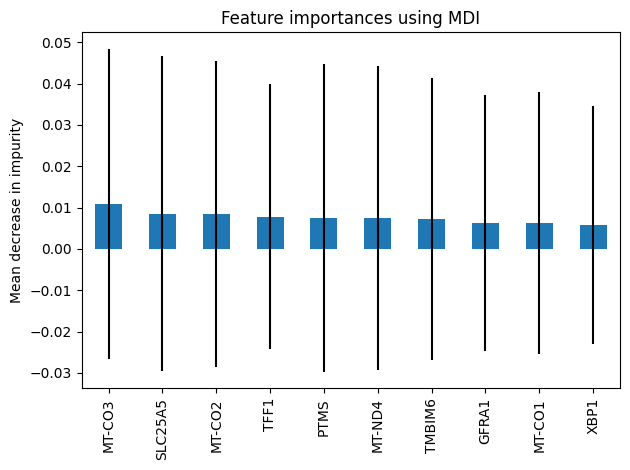

In [160]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std_sorted, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## 6. RFC Permutation Feature Importance Analysis (w/ sensitivity analysis):

In [149]:
##TODO try this out with NNs
# https://scikit-learn.org/stable/modules/permutation_importance.html#id2
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#feature-importance-based-on-mean-decrease-in-impurity 

In [ ]:
# start_time = time.time()
# result = permutation_importance(
#     rfc_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
# )
# elapsed_time = time.time() - start_time
# print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")



In [2]:
# forest_importances = pd.Series(result.importances_mean, index=feature_names)

## 7. Bulk Analysis:

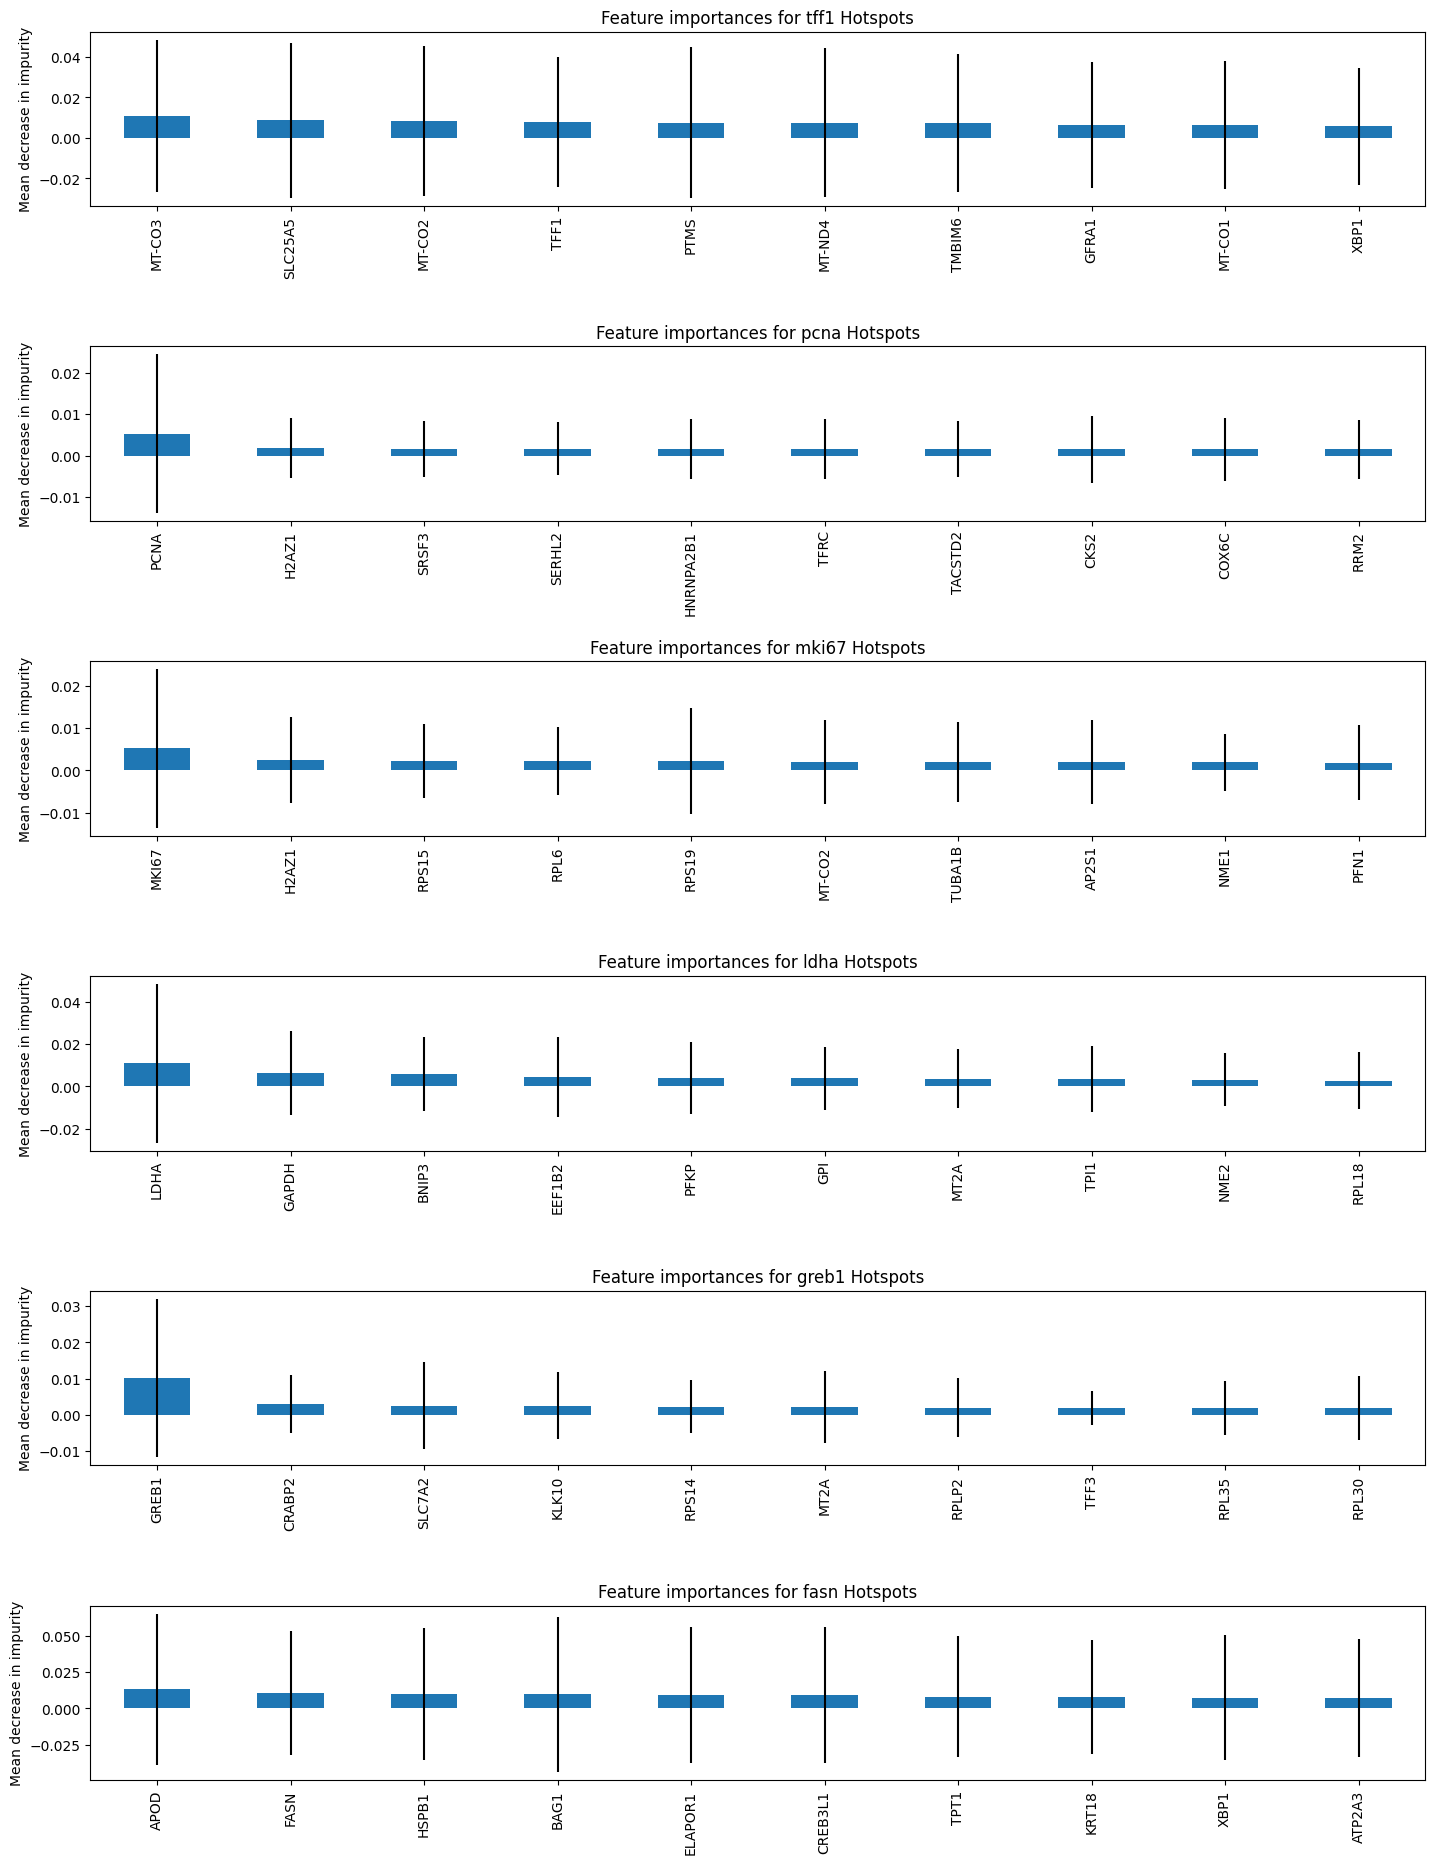

In [27]:
#Bulk Analysis:
# hotspot_tff1 = pd.read_csv("/Users/cmitra/Downloads/unimoran_tff1.csv")
# hotspot_tff1 = pd.read_csv("/Users/cmitra/Downloads/unimoran_tff1.csv")
# hotspot_tff1 = pd.read_csv("/Users/cmitra/Downloads/unimoran_tff1.csv")
# hotspot_tff1 = pd.read_csv("/Users/cmitra/Downloads/unimoran_tff1.csv")
# hotspot_tff1 = pd.read_csv("/Users/cmitra/Downloads/unimoran_tff1.csv")
# hotspot_tff1 = pd.read_csv("/Users/cmitra/Downloads/unimoran_tff1.csv")

biomarkers = ["tff1", "pcna", "mki67", "ldha", "greb1", "fasn"]
scores = []
forest_importance_dict = {}
std_sorted_dict = {}

for gene in biomarkers:
    hotspot_data = pd.read_csv("/Users/cmitra/Downloads/unimoran_" + gene + ".csv")
    
    y_5 = hotspot_data.drop(hotspot_data.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18]], axis=1)
    y_1 = hotspot_data.drop(hotspot_data.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,18]], axis=1)
    y_5 = y_5.values.flatten()
    y_1 = y_1.values.flatten()
    
    for i in range(len(y_5)):
        if y_5[i] == "High-High":# or y_5[i] == "Low-High":
            y_5[i] = 1
        else:
            y_5[i] = 0
        if y_1[i] == "High-High":# or y_1[i] == "Low-High":
            y_1[i] = 1
        else:
            y_1[i] = 0
    y_5 = y_5.astype('int')
    y_1 = y_1.astype('int')
    
    X_train, X_test, y_train, y_test = train_test_split(features, y_5, test_size=.2, random_state=0, shuffle=True, stratify=y_5)
    
    rfc_model = rfc(random_state=0, criterion="entropy")
    #rfc_models[gene] = rfc_model
    
    rfc_model.fit(X_train, y_train)
    scores.append(rfc_model.score(X_test, y_test))
    
    #Feature Importances:
    importances = rfc_model.feature_importances_
    #Save Rank of All Genes to a .csv for Analysis:
    pd.DataFrame({"Feature Importance": list(np.sort(importances)[::-1]), 
                  "Gene": [genes[i] for i in np.argsort(importances)[::-1]]}).to_csv('/Users/cmitra/Downloads/' + gene + '_gene_importance.csv')
    std = np.std([tree.feature_importances_ for tree in rfc_model.estimators_], axis=0)
    
    importances_sorted = np.sort(importances)[-10:][::-1]
    importances_arg_sorted = np.argsort(importances)[-10:][::-1]
    genes_sorted = [genes[i] for i in importances_arg_sorted]
    std_sorted = [std[i] for i in importances_arg_sorted]
    
    #Save the means and std. devs. for plotting:
    forest_importance_dict[gene] = pd.Series(importances_sorted, index=genes_sorted)
    std_sorted_dict[gene] = std_sorted
    
fig, ax = plt.subplots(6, figsize=(16, 20))
fig.tight_layout(pad=8.0)
for i in range(len(biomarkers)):
    forest_importance_dict[biomarkers[i]].plot.bar(yerr=std_sorted_dict[biomarkers[i]], ax=ax[i])
    ax[i].set_title(f"Feature importances for {biomarkers[i]} Hotspots")
    ax[i].set_ylabel("Mean decrease in impurity")


In [26]:
print(f"Validation Scores {scores}")

Validation Scores [0.8936170212765957, 0.9560283687943263, 0.948936170212766, 0.8893617021276595, 0.8453900709219858, 0.9531914893617022]


In [23]:
fig.savefig('/Users/cmitra/Downloads/f837_univariate_feature_importance_plots.png')